### FLICKR8K DATASET Training and Testing

### Libraries import

In [39]:
# Import libraries
import os # operating system library
import numpy as np # numerical python library
import matplotlib.pyplot as plt # plotting library
import re # regular expression library
import torch # deep learning library
from torch import nn, optim # neural network library
from torch.nn import functional as F # functional programming library
from torch.nn.utils.rnn import pad_sequence # padding library
from torchvision import datasets, transforms # vision library
from torch.utils.data import Dataset, DataLoader # to organise the data loading
from torchvision import models, transforms # for the pretrained cnn
from pathlib import Path # take the path of the dataset stored locally
from PIL import Image # image library for showing the images in the dataset
from collections import defaultdict # Dictionary library to store image caption relationships
from collections import Counter # Utilised for the creation of the vocabulary
from pathlib import Path # Used to create the path to store the features
from sklearn.model_selection import train_test_split # data train test splitting


# Use this constant to decide on which device to run the training - On Colab 'cuda:0' and 'cpu' refers to GPU and CPU respectively
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set the random seed for reproducibility
seed = 31
torch.manual_seed(seed)
np.random.seed(seed)


"""Comment
Utilizing pytorch over keras because it is more suitable
for a experiment-heavy training workflow.


"""

'Comment\nUtilizing pytorch over keras because it is more suitable\nfor a experiment-heavy training workflow.\n\n\n'

### Data loading

### Dataset Setup
To download the data, upload your `kaggle.json` file when running the cell below.

In [2]:
from google.colab import files

# Upload your kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


In [3]:
import os

# Configure Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Flickr8k dataset
!kaggle datasets download -d adityajn105/flickr8k

# Unzip the dataset
# This particular dataset extracts directly into 'Images/' and 'captions.txt'
!unzip -q flickr8k.zip

# Verify the extraction
if os.path.exists("Images") and os.path.exists("captions.txt"):
    print("\nSuccess! 'Images' directory and 'captions.txt' are ready.")
else:
    print("\nExtraction finished, but check the directory structure.")

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Images/1000268201_693b08cb0e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
Success! 'Images' directory and 'captions.txt' are ready.


First 5 images visualisation

In [4]:
images_dir = Path("Images")
captions_file = Path("captions.txt")

image_to_captions = defaultdict(list) # Dictionary to store image caption relationships

with open(captions_file, "r", encoding="utf-8") as f:

    # Skip the header

    header = next(f)

    for line in f:
        line = line.strip()
        if not line:
            continue
        fname, caption = line.split(",", 1)
        image_to_captions[fname.strip()].append(caption.strip())



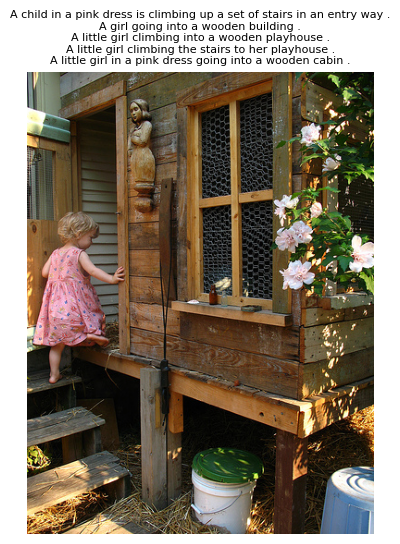

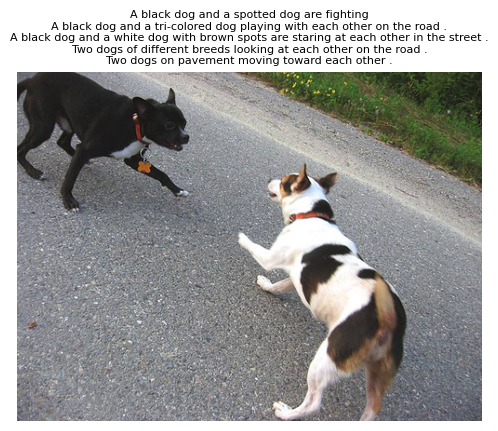

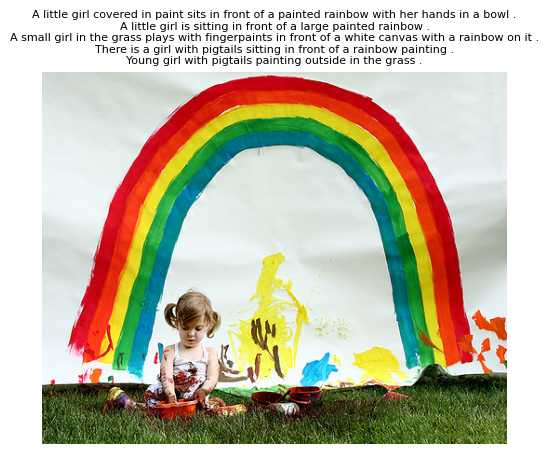

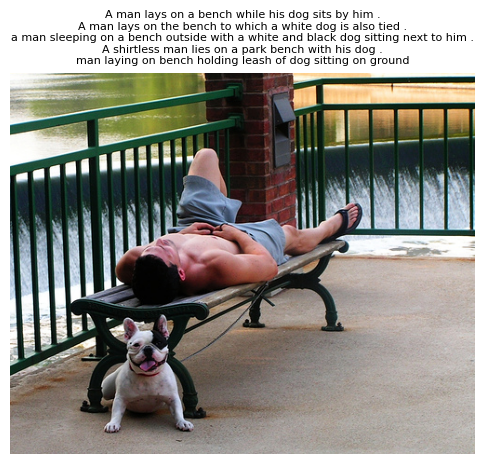

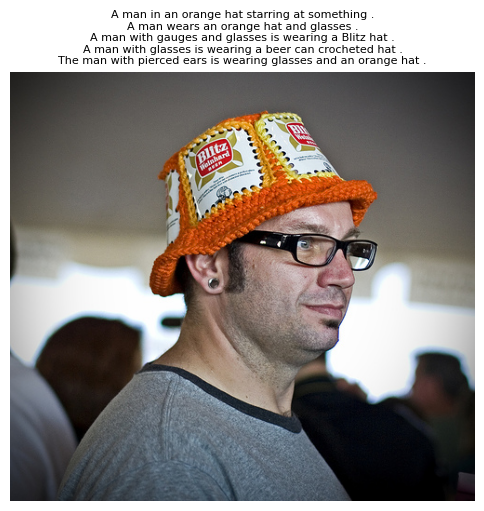

In [5]:
# Visualisation of the first 5 images and their 5 captions
for i, (fname, caps) in enumerate(image_to_captions.items()):
    img_path = os.path.join(images_dir, fname)
    img = Image.open(img_path).convert("RGB")

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")

    # join 5 captions into multi-line title
    title = "\n".join(caps)
    plt.title(title, fontsize=8)
    plt.show()

    if i == 4:    # only first 5 images
        break

### Preprocessing

In [6]:
def clean_caption(text):
    """
    Clean caption text by:
    - Converting to lowercase
    - Removing punctuation
    - Stripping extra whitespace

    Args:
        text (str): Input caption text

    Returns:
        str: Cleaned caption text
    """

    # handle list of captions
    if isinstance(text, list):
        return [clean_caption(t) for t in text]
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)

    # Strip extra whitespace (replace multiple spaces with single space and strip edges)
    text = re.sub(r'\s+', ' ', text).strip()

    return text.strip()

In [7]:
# clean each caption in the dictionary
for line in image_to_captions:

    image_to_captions[line] = clean_caption(image_to_captions[line])



Build vocabulary and convert to IDs



In [27]:
# Build frequency dict
counter = Counter()
for captions in image_to_captions.values():
    for caption in captions:
        cap_clean = clean_caption(caption)
        tokens = cap_clean.split()
        counter.update(tokens)

# Create vocabulary
vocab = sorted(counter.keys())



In [10]:
# Special tokens

PAD, START, END, UNK = "<pad>", "<start>", "<end>", "<unk>"
word2idx = {PAD: 0, START: 1, END: 2, UNK: 3}
idx2word = {i: w for w, i in word2idx.items()}

# In the vocabulary we will keep only the words with a minimum frequency of 5
min_freq = 5
for word, freq in counter.items():
    if freq >= min_freq and word not in word2idx:
        idx = len(word2idx)
        word2idx[word] = idx
        idx2word[idx] = word


# Convert all the words in the caption to their index
def caption_to_ids(tokens):
    ids = [word2idx[START]]
    for t in tokens:
        ids.append(word2idx.get(t, word2idx[UNK]))
    ids.append(word2idx[END])
    return ids


In [11]:
# Make a list of pairs. The first value is the image name, the second is the list of ids of the caption
image_to_ids = []
for image_name, captions in image_to_captions.items():
    for caption in captions:
        cap_clean = clean_caption(caption)
        tokens = cap_clean.split()
        ids = caption_to_ids(tokens)
        image_to_ids.append((image_name, ids))



In [12]:
id_pairs = [(img, ids) for img, ids in image_to_ids]


As we can see now we have encoded the image to the vocabulary tokens of each word. We utilised a simple vocabulary of all the words utilised in the train dataset and converted each word to a specific ID

In [40]:
# Train/test dataset split

train_pairs, val_pairs = train_test_split(
    id_pairs,
    test_size=0.2,
    random_state=31,
    shuffle=True,
)
print(len(train_pairs), len(val_pairs))

32364 8091


### Encoder

Pre-defined CNN: InceptionV3 trained on the ImageNet1k_V1

Why am i utilised an encoder trained on different data?

It is because I want to utilise transfer learning, to reuse a CNN that already learned generic visual features on a huge dataset, and only train the language part (LSTM + attention) on my small dataset.

So, instead of needing Flickr8k to teach the network what a “dog” or “ball” looks like from scratch, I need Flickr8k to teach the mapping from those visual features to words.

Why this is crucial for Flickr8k?

The Flickr*k dataset is quiet small as it has only 8k images, which is not enough to reliably learn all the convolution layers.

Therefore I am utilising InceptionV3 as an unviersal vision front-end that turns any image of the dataset into a reach feature vector

Afterwards I train the LSTM + attention to translate(decode) those features into English sentences for the captions.

In [14]:
# Pretrained InceptionV3
inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
inception.fc = torch.nn.Identity()  # remove classifier, get 2048-d features
inception.eval().to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [15]:
# Generate an image preprocess pipeline
preprocess = transforms.Compose([
    transforms.Resize((299, 299)), # resize the image to size for the InceptionV3
    transforms.ToTensor(), # convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # normalize the image statistics based on ImageNet parameters
                         std=[0.229, 0.224, 0.225]),
])

In [16]:
# function that takes an image file path and returns a feature vector for that image
def extract_feature_for_image(img_path):
    img = Image.open(img_path).convert("RGB") # makes sure all the images are in RGB format
    x = preprocess(img).unsqueeze(0).to(device) #applies the transform pipeline anc convertes it to size {1,3,299,299}
    with torch.no_grad():
        feat = inception(x)   # runs the inception pretrained model on the image and returns the feature vector
    return feat.squeeze(0).cpu()     # returns the feature vector as a numpy array saved on the cpu()


In [17]:
# create the directory to store the features
features_dir = Path("features")
os.makedirs(features_dir, exist_ok=True)

# extract features for each image and save them
for image_name, _ in image_to_ids:
    out_path = features_dir / (image_name.replace(".jpg", ".pt"))
    if out_path.exists():
        continue
    feature = extract_feature_for_image(images_dir/image_name)
    torch.save(feature, out_path)

### Dataset, padding, and DataLoader

In [18]:

class Flickr8kFeatureDataset(Dataset): # creating a custom dataset class
    def __init__(self, id_pairs, feature_root, max_len=None):
        self.samples = id_pairs   # list of (img_id, caption_ids)
        self.feature_root = Path(feature_root) # path to the features
        self.max_len = max_len # maximum length of the caption

    def __len__(self):
        return len(self.samples) # returns the number of samples in the dataset

    def __getitem__(self, idx):
        img_id, cap_ids = self.samples[idx]
        feat_path = self.feature_root / img_id.replace(".jpg", ".pt")
        img_feat = torch.load(feat_path)  # the feature vector of the image     # [2048]
        cap_ids = torch.tensor(cap_ids, dtype=torch.long)
        return img_feat, cap_ids, imgid

PAD_IDX = word2idx[PAD]

# Defining a custom function to batch the data
def collate_fn(batch):
    img_feats, caps = zip(*batch) # using a pointer to unzip a list
    img_feats = torch.stack(img_feats, dim=0)  # Stack according to the batch dimension first[B, 2048]

    lengths = [len(c) for c in caps]
    max_len = max(lengths)
    # create a tensor of the shape (len(caps), max_len) where every element starts with PAD_IDX
    padded = torch.full((len(caps), max_len), PAD_IDX, dtype=torch.long)
    for i, c in enumerate(caps):
        padded[i, :len(c)] = c #make the fist len(c) elements of the tensor equal to the caption ( copying the sequence)
    return img_feats, padded, torch.tensor(lengths, dtype=torch.long), list(imgids)

dataset = Flickr8kFeatureDataset(id_pairs, features_dir) #
# create an iterator that yields mini-batches from the dataset utilising collate_fn to combine the 64 samples into a batch. Needed as all the batches have variable length
loader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)


In [41]:
#create the dataset objects
train_dataset = Flickr8kFeatureDataset(train_pairs, features_dir)
val_dataset   = Flickr8kFeatureDataset(val_pairs,   features_dir)

batch_size = 64

# create an iterator that yields mini-batches from the dataset utilising collate_fn to combine the 64 samples into a batch. Needed as all the batches have variable length


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)


### LSTM with Attention Decoder


In the current arhitecture, I receive 1 2048 multi dimensional vector per image, which makes attention not that useful. I have still decided to implement it, as I could rechange the arhitecture and then the attention layer could provide useufl information.

In [19]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, ctx_dim, attn_dim):
        super().__init__()
        # hidden_dim: decoder hidden size
        # ctx_dim:    context feature size = 2048
        # attn_dim:   internal attention size
        self.W_h = nn.Linear(hidden_dim, attn_dim)
        self.W_c = nn.Linear(ctx_dim, attn_dim)
        self.v   = nn.Linear(attn_dim, 1)

    def forward(self, h_t, ctx):
        """
        h_t:  [B, H]       decoder hidden state at time t
        ctx: [B, C]       image feature (context vector)
        returns:
            context_t: [B, C]
            alpha_t:   [B, 1]   how strongly the decoder attends to each encoder vector
        """
        # Score e_t = v^T tanh(W_h h_t + W_c ctx)
        e = self.v(torch.tanh(self.W_h(h_t) + self.W_c(ctx)))  # [B, 1]
        alpha = torch.softmax(e, dim=1)                        # still [B, 1], =1
        # Weighted sum over "positions" (only one here)
        context_t = alpha * ctx                                # [B, C]
        return context_t, alpha

In [20]:
class DecoderLSTMWithAttention(nn.Module):
    def __init__(self, feature_dim, embed_dim, hidden_dim,
                 vocab_size, pad_idx, attn_dim=256):
        super().__init__()

        # embeding of the next tokens in the caption into vectors
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        # Initialize hidden state from global image feature
        self.init_h = nn.Linear(feature_dim, hidden_dim)
        self.init_c = nn.Linear(feature_dim, hidden_dim) # the cell state

        # Attention over image feature
        self.attn = AdditiveAttention(hidden_dim, feature_dim, attn_dim)

        # LSTM takes [word_emb || context] as input at each step
        # the context has the some size as the feature_dim
        self.lstm = nn.LSTM(embed_dim + feature_dim, hidden_dim, batch_first=True)

        # Output layer over vocabulary, performed by logit, which will later become inputs to the softmax
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, img_feats, captions):
        """
        img_feats: [B, 2048]   precomputed Inception features
        captions: [B, T]       token IDs (with <start> and <end>)
        returns:
            logits: [B, T, V]
        """
        B, T = captions.size()
        device = captions.device

        # Embedding of each token id in the captions to a vector
        embedded = self.embed(captions)   # [B, T, E]

        # Initial hidden and cell from image feature
        h_t = torch.tanh(self.init_h(img_feats)).unsqueeze(0)  # [1, B, H]
        c_t = torch.tanh(self.init_c(img_feats)).unsqueeze(0)  # [1, B, H]

        outputs = []

        # Teacher forcing: loop over time dimension
        for t in range(T):
            # selects the t-th token position in the caption
            x_t = embedded[:, t, :]           # [B, E]

            # Compute attention context from current hidden state and image feature
            h_top = h_t[-1]                   # [B, H] (top layer)
            ctx_t, _ = self.attn(h_top, img_feats)  # ctx_t: [B, C] computes the context based on the last hidden layer and the embedding of the photos

            # Concatenate word embedding and context
            lstm_input = torch.cat([x_t, ctx_t], dim=-1).unsqueeze(1)  # [B, 1, E+C]

            # One LSTM step with the current word embedding and the context with the hidden and cell states
            out_t, (h_t, c_t) = self.lstm(lstm_input, (h_t, c_t))  # out_t: [B, 1, H]
            outputs.append(out_t)

        # Concatenate all time steps
        outputs = torch.cat(outputs, dim=1)      # [B, T, H]
        logits = self.fc(outputs)                # [B, T, V]
        return logits


In [21]:
model = DecoderLSTMWithAttention(
    feature_dim=2048,
    embed_dim=256,
    hidden_dim=512,
    vocab_size=len(word2idx),
    pad_idx=PAD_IDX,
    attn_dim=256
).to(device)


### Inference

In [22]:
device = torch.device("cpu")
vocab_size = len(word2idx)
model = DecoderLSTMWithAttention(feature_dim=2048, embed_dim=256, hidden_dim=512,
                    vocab_size=vocab_size, pad_idx=PAD_IDX).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img_feats, caps, lengths in train_loader:
        img_feats = img_feats.to(device)
        caps = caps.to(device)

        # Teacher forcing: predict next token given all previous
        inputs = caps[:, :-1]
        targets = caps[:, 1:]

        logits = model(img_feats, inputs)      # [B, T-1, V]
        loss = criterion(
            logits.reshape(-1, vocab_size),
            targets.reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss = {total_loss / len(loader):.4f}")


Epoch 1: loss = 3.7385
Epoch 2: loss = 2.9292
Epoch 3: loss = 2.6527
Epoch 4: loss = 2.4686
Epoch 5: loss = 2.3210
Epoch 6: loss = 2.1922
Epoch 7: loss = 2.0804
Epoch 8: loss = 1.9767
Epoch 9: loss = 1.8812
Epoch 10: loss = 1.7924
Epoch 11: loss = 1.7114
Epoch 12: loss = 1.6318
Epoch 13: loss = 1.5581
Epoch 14: loss = 1.4888
Epoch 15: loss = 1.4254
Epoch 16: loss = 1.3639
Epoch 17: loss = 1.3068
Epoch 18: loss = 1.2513
Epoch 19: loss = 1.1997
Epoch 20: loss = 1.1490


The model decreases less and less after 5 epochs, however i imagine the training could eb done faster

Now we will implement a BLEU benchmark to see the quality of the code

In [23]:
!pip install nltk
import nltk
nltk.download('punkt')

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [31]:
#Helper function to generate caption
def ids_to_tokens(id_seq, idx2word, end_token="<end>"):
    tokens = []
    for idx in id_seq:
        word = idx2word.get(int(idx), "<unk>")
        if word == end_token:
            break
        if word not in ["<pad>", "<start>"]:
            tokens.append(word)
    return tokens

def generate_batch_captions(model, img_feats_batch, word2idx, idx2word,
                            max_len=20, device="cpu"):
    model.eval()
    img_feats_batch = img_feats_batch.to(device)
    B = img_feats_batch.size(0)
    captions = [[] for _ in range(B)]

    with torch.no_grad():
        h = torch.tanh(model.init_h(img_feats_batch)).unsqueeze(0)
        c = torch.tanh(model.init_c(img_feats_batch)).unsqueeze(0)

        start_id = word2idx["<start>"]
        end_id = word2idx["<end>"]
        inputs = torch.full((B, 1), start_id, dtype=torch.long, device=device)
        finished = torch.zeros(B, dtype=torch.bool, device=device)

        for _ in range(max_len):
            emb = model.embed(inputs)              # [B, 1, E]
            out, (h, c) = model.lstm(emb, (h, c))  # [B, 1, H]
            logits = model.fc(out[:, -1, :])       # [B, V]
            logits[:, unk_id] = -1e9
            next_ids = logits.argmax(dim=-1)       # [B]

            inputs = next_ids.unsqueeze(1)
            for i in range(B):
                if finished[i]:
                    continue
                tid = int(next_ids[i])
                if tid == end_id:
                    finished[i] = True
                else:
                    captions[i].append(tid)
            if finished.all():
                break

    return [ids_to_tokens(seq, idx2word) for seq in captions]

def collect_refs_and_cands(model, dataloader, word2idx, idx2word,
                           imagetocaptions,
                           device="cpu", maxlen=20):
    all_refs = []   # list of list-of-reference-captions
    all_cands = []  # list of candidate token lists

    model.eval()
    with torch.no_grad():
        for imgfeats, caps, lengths, imgids in dataloader:
            imgfeats = imgfeats.to(device)

            # generate candidate captions (already token lists)
            cands = generate_batch_captions(
                model, imgfeats, word2idx, idx2word,
                max_len=maxlen, device=device
            )

            for i, imgid in enumerate(imgids):
                # get raw references from captions.txt
                refs_raw = imagetocaptions[imgid]   # list of 5 strings

                # tokenize each reference caption
                refs_tok = [ref.split() for ref in refs_raw]

                all_refs.append(refs_tok)
                all_cands.append(cands[i])

    return all_refs, all_cands


def compute_bleu_scores(all_refs, all_cands):
    chencherry = SmoothingFunction()
    bleu1 = corpus_bleu(all_refs, all_cands,
                        weights=(1.0, 0, 0, 0),
                        smoothing_function=chencherry.method1)
    bleu2 = corpus_bleu(all_refs, all_cands,
                        weights=(0.5, 0.5, 0, 0),
                        smoothing_function=chencherry.method1)
    bleu3 = corpus_bleu(all_refs, all_cands,
                        weights=(1/3, 1/3, 1/3, 0),
                        smoothing_function=chencherry.method1)
    bleu4 = corpus_bleu(all_refs, all_cands,
                        weights=(0.25, 0.25, 0.25, 0.25),
                        smoothing_function=chencherry.method1)
    return bleu1, bleu2, bleu3, bleu4


In [35]:
import torch.nn.functional as F

def generate_caption_single_beam(model, img_feat, word2idx, idx2word,
                                 max_len=20, beam_size=5, device="cpu"):
    model.eval()
    img_feat = img_feat.unsqueeze(0).to(device)  # [1, 2048]

    start_id = word2idx["<start>"]
    end_id   = word2idx["<end>"]
    unk_id   = word2idx["<unk>"]

    with torch.no_grad():
        # init LSTM state from image
        h0 = torch.tanh(model.init_h(img_feat)).unsqueeze(0)  # [1, 1, H]
        c0 = torch.tanh(model.init_c(img_feat)).unsqueeze(0)  # [1, 1, H]

        # each beam: (log_prob, [token_ids], h, c)
        beams = [(0.0, [start_id], h0, c0)]
        completed = []

        for _ in range(max_len):
            new_beams = []

            for log_p, seq, h, c in beams:
                last_id = seq[-1]
                if last_id == end_id:
                    completed.append((log_p, seq))
                    continue

                # one‑step decode
                inputs = torch.tensor([[last_id]], dtype=torch.long, device=device)
                emb = model.embed(inputs)          # [1, 1, E]
                x_t = emb[:, 0, :]                 # [1, E]

                ctx_t, _ = model.attn(h[-1], img_feat)                # [1, C]
                lstm_in = torch.cat([x_t, ctx_t], dim=-1).unsqueeze(1) # [1,1,E+C]
                out, (h_new, c_new) = model.lstm(lstm_in, (h, c))     # [1,1,H]

                logits = model.fc(out[:, -1, :])                      # [1, V]
                logits[0, unk_id] = -1e9                              # avoid <unk>
                log_probs = F.log_softmax(logits, dim=-1).squeeze(0)  # [V]

                # top‑k next tokens for this beam
                top_logp, top_ids = torch.topk(log_probs, beam_size)

                for lp, wid in zip(top_logp, top_ids):
                    wid = int(wid.item())
                    new_seq = seq + [wid]
                    new_log_p = log_p + float(lp.item())
                    new_beams.append((new_log_p, new_seq, h_new, c_new))

            # if all beams ended
            if not new_beams:
                break

            # keep global top beam_size beams
            new_beams.sort(key=lambda x: x[0], reverse=True)
            beams = new_beams[:beam_size]

        # add remaining beams as completed
        for log_p, seq, _, _ in beams:
            completed.append((log_p, seq))

        # choose best finished sequence
        completed.sort(key=lambda x: x[0], reverse=True)
        best_seq = completed[0][1]

    # drop start/end/pad and convert to words
    caption_ids = [
        i for i in best_seq
        if idx2word[i] not in ["<pad>", "<start>", "<end>"]
    ]
    return " ".join(idx2word[i] for i in caption_ids)


Image: 2765747519_2b851e01d6.jpg
Generated captions:
  a baby in a green jacket is sitting in a green bag
Reference captions:
  1. a baby in a green bag peeks out
  2. a child is mostly hidden in a green shopping bag
  3. a child is sitting in a green tote bag with only its eyes and hair poking out
  4. infant peers from a limegreen shopping bag
  5. little baby is peeking out of a green grocery bag


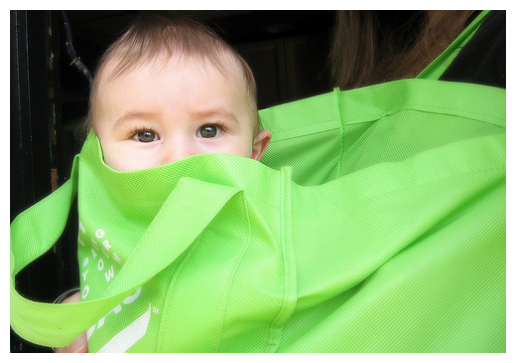

Image: 2344699642_4fae2f4e07.jpg
Generated captions:
  a dog is jumping to catch a purple frisbee
Reference captions:
  1. a brown and white dog in the air next two a purple frisbee above grass
  2. a brown dog is jumping in the air whilst trying to catch a purple frisbee
  3. a dog is jumping to catch a frisbee
  4. a dog jumps to catch a flying disc
  5. a dog jumps to catch the purple frisbee


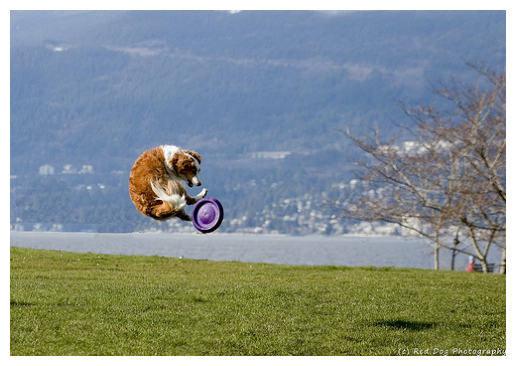

Image: 3454355269_6185e29f95.jpg
Generated captions:
  a person rides a bike through a forest
Reference captions:
  1. a man with a helmet rides his bike on a bumpy path
  2. a mountain biker rides across a rocky terrain
  3. a person in a red jacket riding a mountain bike
  4. a person on a bike is riding through a rocky trail in the woods
  5. man in safety gear riding a bike on a rocky trail


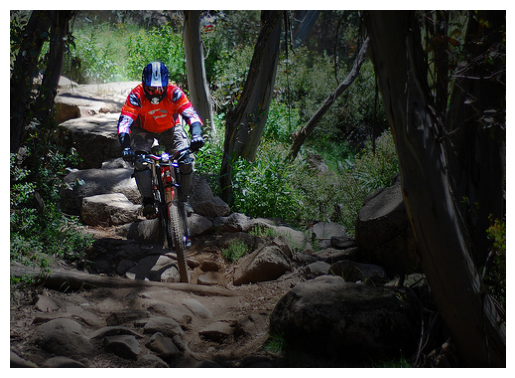

Image: 2973272684_4d63cbc241.jpg
Generated captions:
  a football player runs with the ball
Reference captions:
  1. a football player in a gold helmet is running with a football
  2. a football player in a purple jersey is running the ball in for a touchdown
  3. a football player runs across the field as the referee blows his whistle
  4. a football player runs past an official carrying a football
  5. the football player runs the ball past the referee


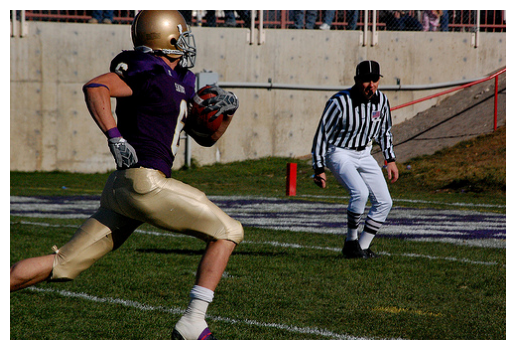

Image: 2650620212_0586016e0d.jpg
Generated captions:
  a black dog is walking on the edge of a pool
Reference captions:
  1. a black dog is walking along the side of a pool
  2. a black dog runs around an outdoor swimming pool
  3. a black dog walking beside a pool
  4. a black poodle walks on the edge of a pool
  5. a fluffy blank poodle is walking on the edge of a pool


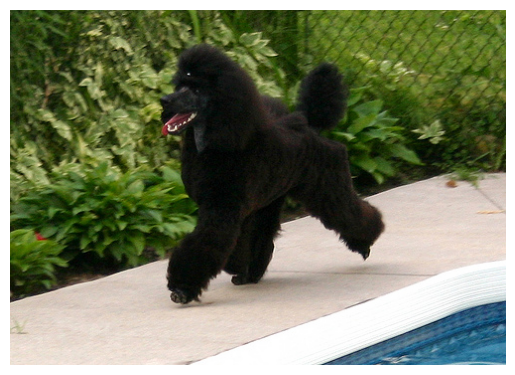

In [37]:
import random
from PIL import Image
import matplotlib.pyplot as plt

samples = random.sample(id_pairs, 5)

for img_id, cap_ids in samples:
    img_path = images_dir / img_id
    feat_path = features_dir / img_id.replace(".jpg", ".pt")
    img_feat = torch.load(feat_path)

    # generate 5 captions from the model (e.g. independent greedy runs)
    gen_captions = []

    gen_caption = generate_caption_single_beam(
            model, img_feat, word2idx, idx2word,
            max_len=20, device=device
        )
    gen_captions.append(gen_caption)

    # get all 5 original captions from captions.txt
    refs = image_to_captions[img_id]   # list of 5 strings

    plt.imshow(Image.open(img_path).convert("RGB"))
    plt.axis("off")
    print("Image:", img_id)

    print("Generated captions:")

    print(f"  {gen_captions[0]}")

    print("Reference captions:")
    for i, rc in enumerate(refs, 1):
        print(f"  {i}. {rc}")

    plt.show()
